# Process Small Radar Ranging file to obtain range as a function of time

In [1]:
import scipy.io.wavfile
import scipy.constants
import pylab
import numpy as np
%matplotlib notebook

In [2]:
# read WAV file
fname = "ionelectrons.wav"
rate,d = scipy.io.wavfile.read(fname)

In [3]:
#radar parameters
Tp = 20E-3; # (s) pulse time; we only use the upward chirp
N = int(Tp*rate); # of samples per pulse
fstart = 2374E6 #(Hz) LFM start frequency
fstop = 2454E6 #(Hz) LFM stop frequency

In [4]:
# transmit frequency, bandwidth
BW = fstop-fstart # (Hz) transmit bandwidth
f = np.linspace(fstart, fstop, int(N/2)) # instantaneous transmit frequency

In [5]:
# range resolution
rr = scipy.constants.c/(2*BW)
max_range = rr*int(N/2)
print('Range resolution: {:.3f} meters'.format(rr))

Range resolution: 1.874 meters


In [6]:
# convert data into 2D array with column count = analysis block length
s = np.array(-1*d[:,1],float) # the input appears to be inverted, so correct that
trig = np.array(-1*d[:,0],float) # trigger input (square wave)

In [7]:
# parse the data here by triggering off rising edge of sync pulse
# only use the positive going chirp

thresh = 0

start = (trig>thresh)  # 1 if above threshold, 0 if not

slist = []
tlist = []

for ii in range(100,(start.shape[0]-N)):
    if start[ii] == 1:
        # check the last 10 samples; if they were zero, we found the edge
        if (start[ii-10:ii]).mean() == 0:
            # record the upsweep
            slist.append(s[ii:ii+N])
            tlist.append(ii*1/rate)
            
print('Found {} sweeps'.format(len(tlist)))

Found 725 sweeps


In [8]:
# convert slist and tlist to arrays
tlist = np.array(tlist)
sif = np.zeros((len(tlist),N))
for k in range(sif.shape[0]):
    sif[k,:] = slist[k]

In [9]:
# subtract mean from each sweep
meanvec = np.mean(sif,axis=0)
meanvec.shape = (1,-1)
meanmat = np.ones((sif.shape[0],1))*meanvec
sif -= meanmat

In [10]:
# convert time to frequency
pad_factor = 8
S = np.fft.fft(sif,N*pad_factor) # pad with zeros for interpolated resolution
S = S[:,:int(S.shape[1]/2)] # only keep the positive half

In [11]:
# convert voltage to power and normalize by largest signal return
SL = 20*np.log10(abs(S))  # convert voltage to power
SL -= SL.max().max()      # largest signal return at 0 dB

In [12]:
# set up range axis
rng = np.linspace(0, max_range, num=int(N*pad_factor/2))

In [13]:
# keep only those ranges that we are going to plot
rng_max = 20 # m
indx = np.where(rng < rng_max)[0]
rng = rng[indx]
SL = SL[:,indx]

<IPython.core.display.Javascript object>


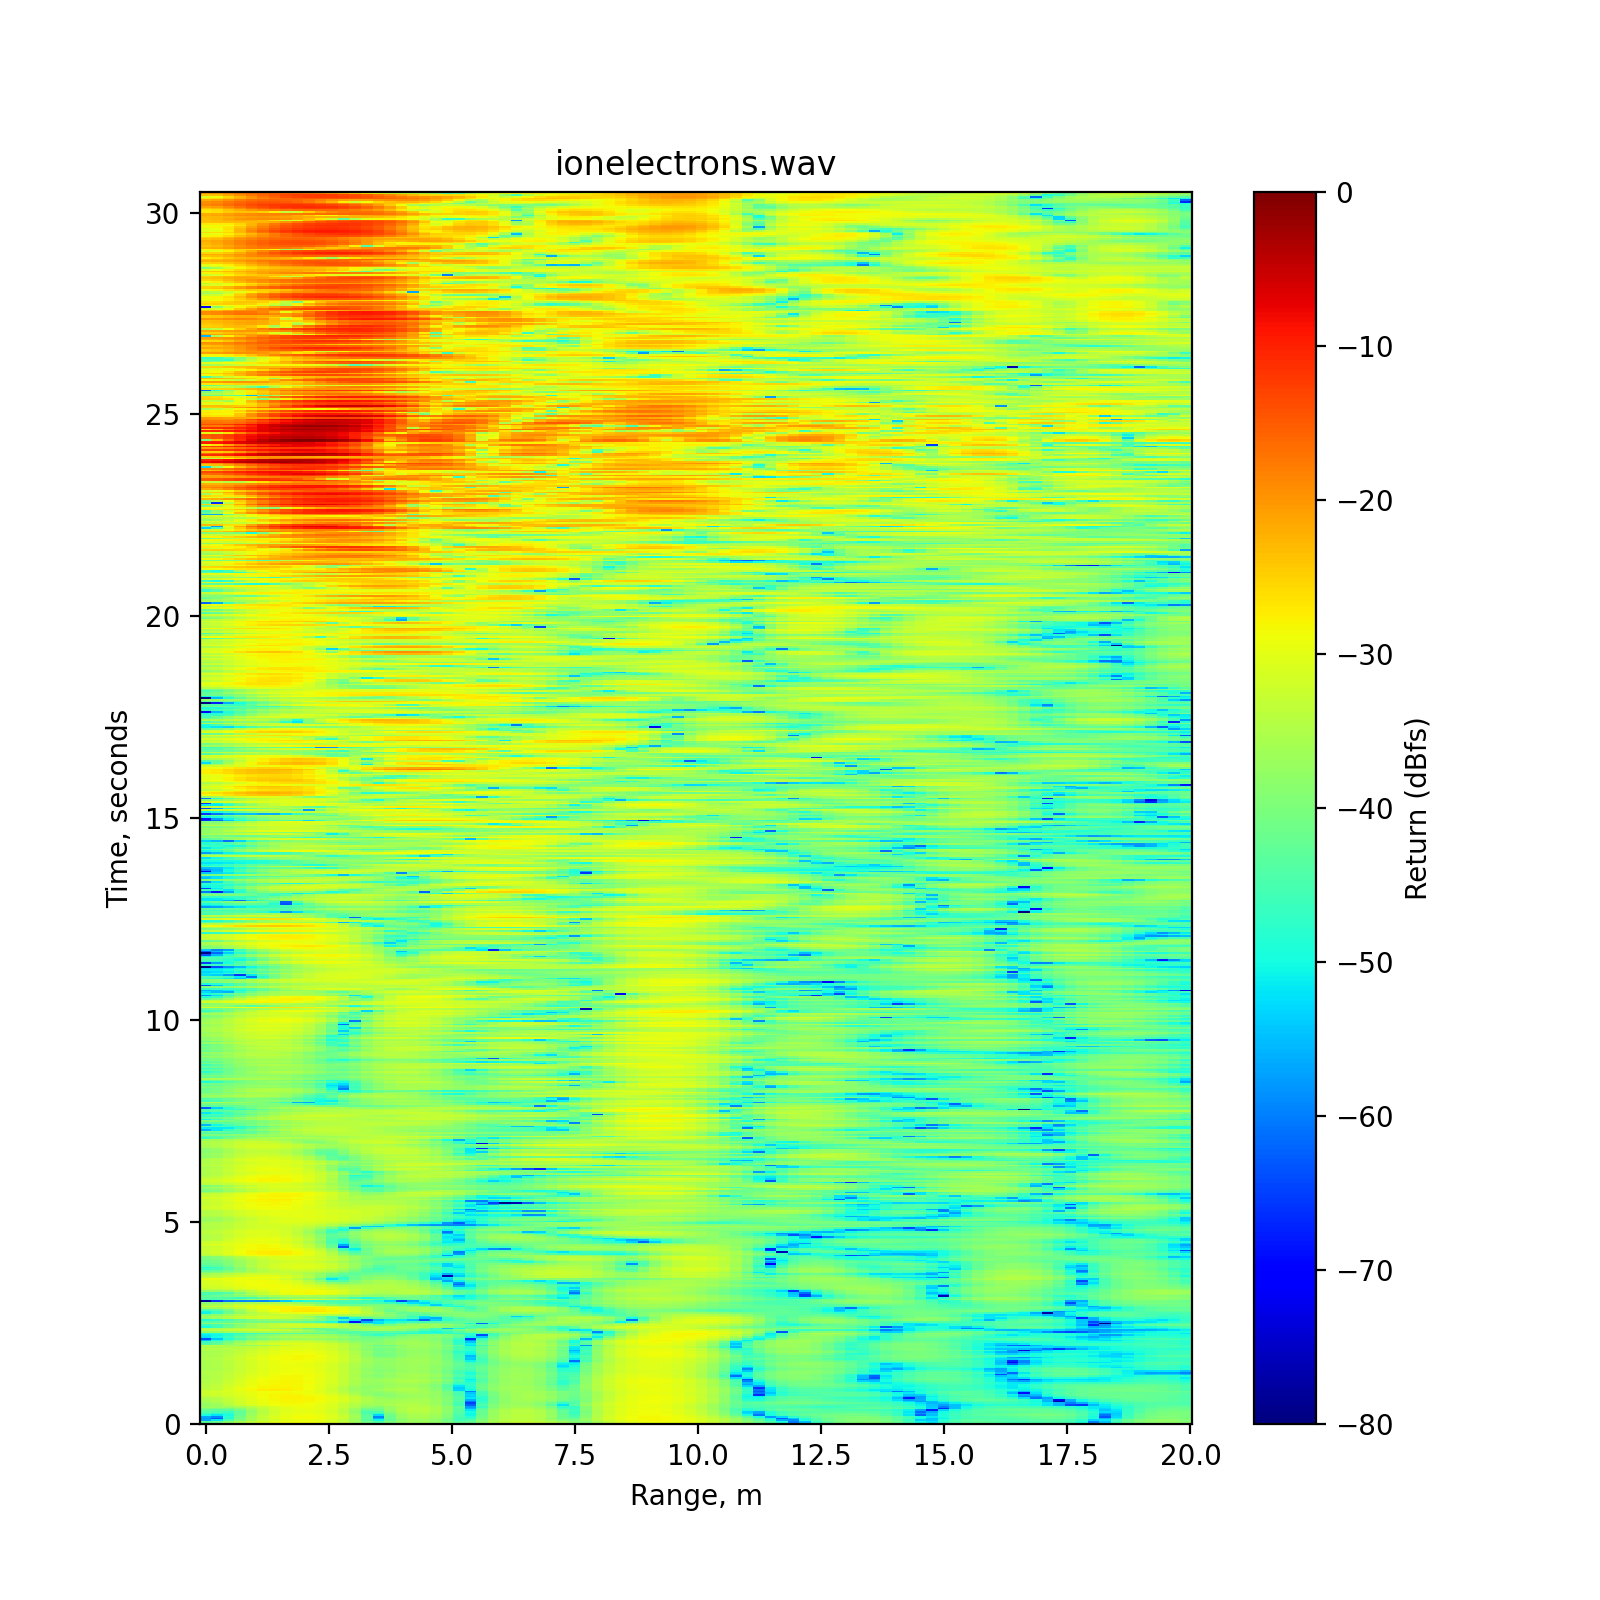

Text(0.5, 1.0, 'ionelectrons.wav')

In [14]:
# plot range tracks
f,ax = pylab.subplots(figsize=(8,8))
h = ax.pcolor(rng, tlist, SL,vmin=-80,vmax=0,cmap='jet')
f.colorbar(h,label='Return (dBfs)')
ax.set_ylabel('Time, seconds')
ax.set_xlabel('Range, m')
ax.set_title(fname)

In [21]:
# apply 2 pulse canceller
sif2 = sif[1:,:] - sif[:-1,:]
tlist2 = tlist[1:] # adjust time vector since we now have one fewer time sample

In [22]:
# convert time to frequency
pad_factor = 8
S2 = np.fft.fft(sif2,N*pad_factor) # pad with zeros for interpolated resolution
S2 = S2[:,:int(S2.shape[1]/2)] # only keep the positive half

In [23]:
# convert voltage to power and normalize by largest signal return
SL2 = 20*np.log10(abs(S2))  # convert voltage to power
SL2 -= SL2.max().max()      # largest signal return at 0 dB

In [24]:
# set up range axis
rng2 = np.linspace(0, max_range, num=int(N*pad_factor/2))

In [25]:
# keep only those range we are going to plot
indx = np.where(rng2 < rng_max)[0]
rng2 = rng2[indx]
SL2 = SL2[:,indx]

<IPython.core.display.Javascript object>


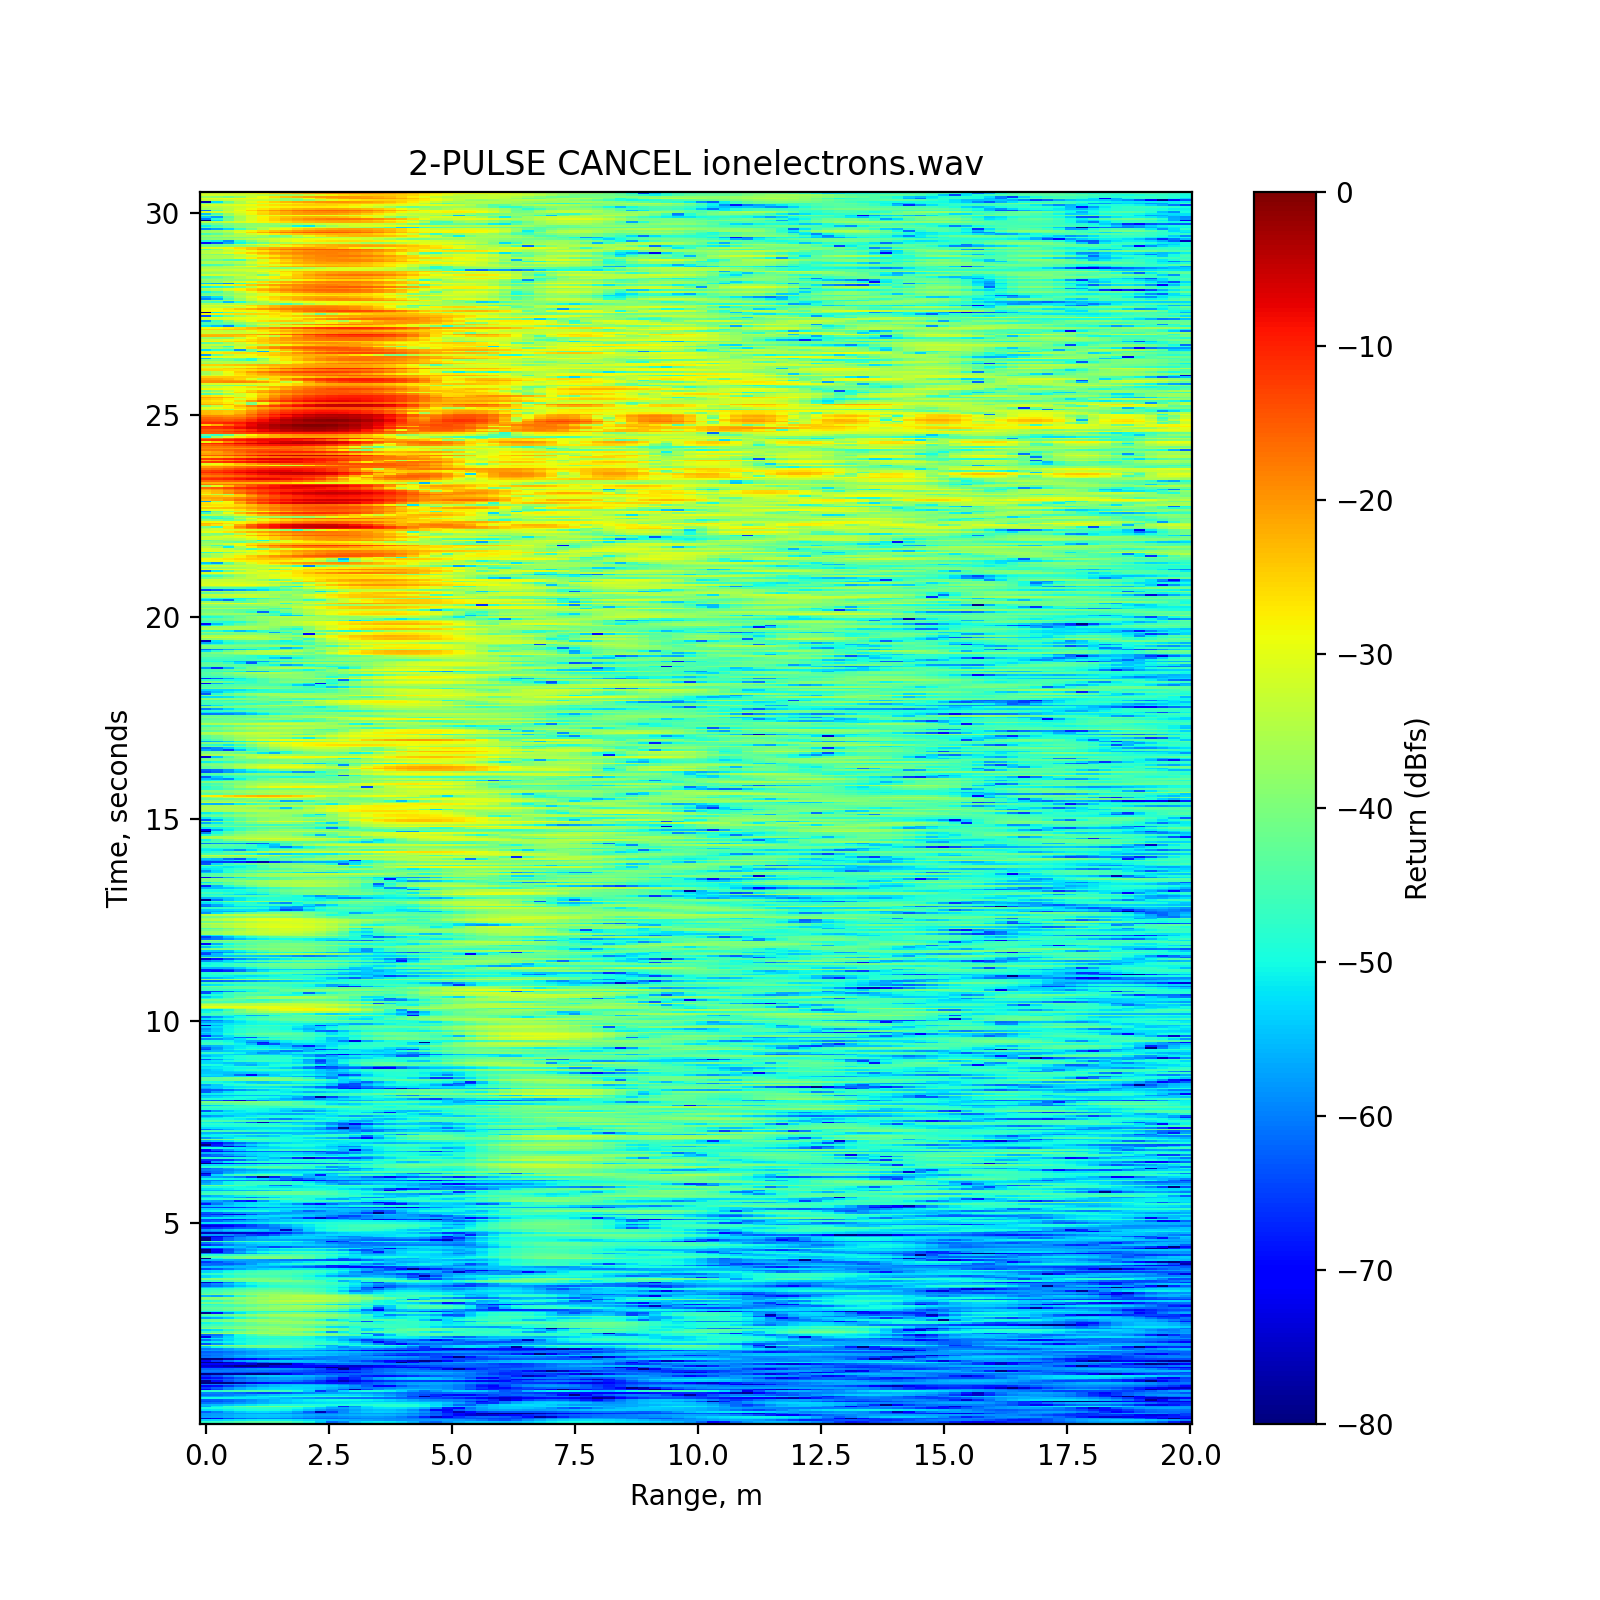

Text(0.5, 1.0, '2-PULSE CANCEL ionelectrons.wav')

In [26]:
# plot range tracks
f,ax = pylab.subplots(figsize=(8,8))
h = ax.pcolor(rng2, tlist2, SL2,vmin=-80,vmax=0,cmap='jet')
f.colorbar(h,label='Return (dBfs)')
ax.set_ylabel('Time, seconds')
ax.set_xlabel('Range, m')
ax.set_title('2-PULSE CANCEL ' + fname)